### Systematic comparison of topics across conditions using quantitative similarity measurement

We calculate the semantic similarity between the topics from the two conditions directly from the sentence embedding

1. Create a Single "Topic Vector": For each topic in both HS and DL, calculate its average vector. We do this by taking the sentence embeddings of all sentences assigned to that topic and averaging them. This gives a single vector that represents the semantic center of that topic.

2. Calculate Cosine Similarity: Use cosine similarity to measure the angle between each HS topic vector and each DL topic vector. The output will be a score between 0 and 1*, where 1 means they are semantically identical.

3. Visualise with a Heatmap: Place the HS topics on the Y-axis and the DL topics on the X-axis. The colour of each cell would represent the cosine similarity score between the two topics.



* (with modern sentence embeddings, instead of -1 to 1). This happens because of how models are trained (designed to place sentences with similar meanings closer in the vector space, so vectors they produce tend to exist in the "first quadrant" of the high-dimensional space ie  most of their component values are positive).

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


import os,sys 
# current_dir = os.getcwd()
# project_root = os.path.dirname(current_dir)  
# sys.path.append(project_root)

current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..', '../..'))  # goes two levels up to MOSAIC
print("Project root:",project_root)
sys.path.append(project_root)
from configs.dreamachine2 import config



dataset = 'dreamachine'
results_dir = os.path.join(project_root, "EVAL",dataset.lower())
topic_content_HS = pd.read_csv(os.path.join(results_dir, f"topics_content/topic_content_HS_final.csv"))
topic_content_DL = pd.read_csv(os.path.join(results_dir, f"topics_content/topic_content_DL_final.csv"))

Project root: /Users/rb666/Projects/MOSAIC


In [98]:
list(topic_content_HS.Topic_Label)

['Visual Perception of Kaleidoscopic Patterns and Colors',
 'Out-of-Body Experiences and Cosmic Dream-Like Consciousness',
 'Unlabelled',
 'Experience of Time and Space Distortions',
 'Mindfulness and Music Based Sensory Experience for Calm and Peace',
 'Spiritual or Meditative Experience with Euphoric Sensations',
 'Subjective Experience of Therapeutic Potential',
 'Nostalgic Memory Recall Phenomenon',
 'Synesthetic Sensory and Emotional Experience',
 'Visual Sensitivity to Flashing Light Intensity',
 'Phenomenological Experience of Disorientation and Anxiety',
 'Psychedelic Experience and Potential for Trauma Processing',
 'Near-Death Experience and Existential Reflections']

In [99]:
list(topic_content_DL.Topic_Label)

['Mindfulness and Relaxation Through Sound Experience',
 'Spiritual Experiences of Connection and Self-Discovery',
 'Phenomenology of Visual Perception in Closed Eyes',
 'Imagery and Perception of Aquatic Environments',
 'Out-of-Body Experience',
 'Outlier',
 'Space-Time Imagery and Perception',
 'The Power of Music on Spatial Perception']

# Method 1

In [100]:
df_hs = topic_content_HS
df_dl = topic_content_DL

hs_counts = df_hs.set_index('Topic_Label')['Sentence_Count'].rename('HS')
dl_counts = df_dl.set_index('Topic_Label')['Sentence_Count'].rename('DL')

contingency_table = pd.concat([hs_counts, dl_counts], axis=1).fillna(0).astype(int)

if 'Outlier' in contingency_table.index:
    contingency_table = contingency_table.drop('Outlier')

if 'Unlabelled' in contingency_table.index:
    contingency_table = contingency_table.drop('Unlabelled')

print("\n--- Contingency Table (Observed Frequencies) ---")
print(contingency_table)
print("-------------------------------------------------")


--- Contingency Table (Observed Frequencies) ---
                                                     HS  DL
Topic_Label                                                
Visual Perception of Kaleidoscopic Patterns and...  191   0
Out-of-Body Experiences and Cosmic Dream-Like C...  125   0
Experience of Time and Space Distortions             58   0
Mindfulness and Music Based Sensory Experience ...   54   0
Spiritual or Meditative Experience with Euphori...   40   0
Subjective Experience of Therapeutic Potential       33   0
Nostalgic Memory Recall Phenomenon                   29   0
Synesthetic Sensory and Emotional Experience         27   0
Visual Sensitivity to Flashing Light Intensity       24   0
Phenomenological Experience of Disorientation a...   24   0
Psychedelic Experience and Potential for Trauma...   14   0
Near-Death Experience and Existential Reflections    13   0
Mindfulness and Relaxation Through Sound Experi...    0  50
Spiritual Experiences of Connection and Self-Di...

# Method 2

In [101]:
# Convert topic_content_HS to the same structure as hs_df
hs_df_full = topic_content_HS.explode('Content').reset_index(drop=True)
# If 'Content' is a string representation of a list, eval it first
if isinstance(hs_df_full.loc[0, 'Content'], str):
    hs_df_full = topic_content_HS.copy()
    hs_df_full['Content'] = hs_df_full['Content'].apply(eval)
    hs_df_full = hs_df_full.explode('Content').reset_index(drop=True)
hs_df_full = hs_df_full.rename(columns={'Topic_Label': 'topic', 'Content': 'text'})
hs_df_full = hs_df_full[['topic', 'text']]

# Convert topic_content_DL to the same structure as dl_df
dl_df_full = topic_content_DL.copy()
dl_df_full['Content'] = dl_df_full['Content'].apply(eval)
dl_df_full = dl_df_full.explode('Content').reset_index(drop=True)
dl_df_full = dl_df_full.rename(columns={'Topic_Label': 'topic', 'Content': 'text'})
dl_df_full = dl_df_full[['topic', 'text']]

print(hs_df_full.head())
print(dl_df_full.head())

                                               topic  \
0  Visual Perception of Kaleidoscopic Patterns an...   
1  Visual Perception of Kaleidoscopic Patterns an...   
2  Visual Perception of Kaleidoscopic Patterns an...   
3  Visual Perception of Kaleidoscopic Patterns an...   
4  Visual Perception of Kaleidoscopic Patterns an...   

                                                text  
0  A pattern of red and white lights that flashed...  
1                                   Hope as a color.  
2                 Incredible technicolor experience.  
3  At one point, the light darkened and my vision...  
4                    Incredible colors and patterns.  
                                               topic  \
0  Mindfulness and Relaxation Through Sound Exper...   
1  Mindfulness and Relaxation Through Sound Exper...   
2  Mindfulness and Relaxation Through Sound Exper...   
3  Mindfulness and Relaxation Through Sound Exper...   
4  Mindfulness and Relaxation Through Sound Exper... 

### Generate sentence embeddings

In [102]:
# Load a pre-trained model
model = SentenceTransformer(config.transformer_model)
print(f"\n--- Loaded SentenceTransformer Model: {config.transformer_model} ---")

# # Generate embeddings for each dataset
hs_df_full['embedding'] = list(model.encode(hs_df_full['text']))
dl_df_full['embedding'] = list(model.encode(dl_df_full['text']))

print("\n--- Sentence Embeddings Generated ---")
print("Embeddings have been added as a new column to the DataFrames.")


--- Loaded SentenceTransformer Model: Qwen/Qwen3-Embedding-0.6B ---

--- Sentence Embeddings Generated ---
Embeddings have been added as a new column to the DataFrames.


In [103]:
# Filter out the 'Outlier' topic from both dataframes before grouping
# hs_df_filtered = hs_df_full[hs_df_full['topic'] != 'Outlier']
hs_df_filtered = hs_df_full[hs_df_full['topic'] != 'Unlabelled']
dl_df_filtered = dl_df_full[dl_df_full['topic'] != 'Outlier']

# We group by topic and calculate the average embedding for that topic.
hs_topic_vectors = hs_df_filtered.groupby('topic')['embedding'].apply(np.mean)
dl_topic_vectors = dl_df_filtered.groupby('topic')['embedding'].apply(np.mean)


print("\n--- Topic Vectors Created (Outliers Removed) ---")
print("HS Topics:")
print(hs_topic_vectors.index.tolist())
print("\nDL Topics:")
print(dl_topic_vectors.index.tolist())


--- Topic Vectors Created (Outliers Removed) ---
HS Topics:
['Experience of Time and Space Distortions', 'Mindfulness and Music Based Sensory Experience for Calm and Peace', 'Near-Death Experience and Existential Reflections', 'Nostalgic Memory Recall Phenomenon', 'Out-of-Body Experiences and Cosmic Dream-Like Consciousness', 'Phenomenological Experience of Disorientation and Anxiety', 'Psychedelic Experience and Potential for Trauma Processing', 'Spiritual or Meditative Experience with Euphoric Sensations', 'Subjective Experience of Therapeutic Potential', 'Synesthetic Sensory and Emotional Experience', 'Visual Perception of Kaleidoscopic Patterns and Colors', 'Visual Sensitivity to Flashing Light Intensity']

DL Topics:
['Imagery and Perception of Aquatic Environments', 'Mindfulness and Relaxation Through Sound Experience', 'Out-of-Body Experience', 'Phenomenology of Visual Perception in Closed Eyes', 'Space-Time Imagery and Perception', 'Spiritual Experiences of Connection and Self

### Calculate Cosine Similarity Between HS and DL Topics

In [104]:
# Create a matrix to store the similarity scores
similarity_matrix = pd.DataFrame(index=hs_topic_vectors.index, columns=dl_topic_vectors.index)

# Loop through each pair of topics and calculate their similarity
for hs_topic, hs_vector in hs_topic_vectors.items():
    for dl_topic, dl_vector in dl_topic_vectors.items():
        # Reshape vectors for the function
        sim_score = cosine_similarity(hs_vector.reshape(1, -1), dl_vector.reshape(1, -1))
        similarity_matrix.loc[hs_topic, dl_topic] = sim_score[0, 0]

# Convert the matrix to float type for the heatmap
similarity_matrix = similarity_matrix.astype(float)

print("\n--- Cosine Similarity Matrix ---")
print(similarity_matrix)



--- Cosine Similarity Matrix ---
topic                                               Imagery and Perception of Aquatic Environments  \
topic                                                                                                
Experience of Time and Space Distortions                                                  0.730695   
Mindfulness and Music Based Sensory Experience ...                                        0.697538   
Near-Death Experience and Existential Reflections                                         0.720553   
Nostalgic Memory Recall Phenomenon                                                        0.781721   
Out-of-Body Experiences and Cosmic Dream-Like C...                                        0.870808   
Phenomenological Experience of Disorientation a...                                        0.768115   
Psychedelic Experience and Potential for Trauma...                                        0.670985   
Spiritual or Meditative Experience with Euphori.


--- Generating Heatmap ---


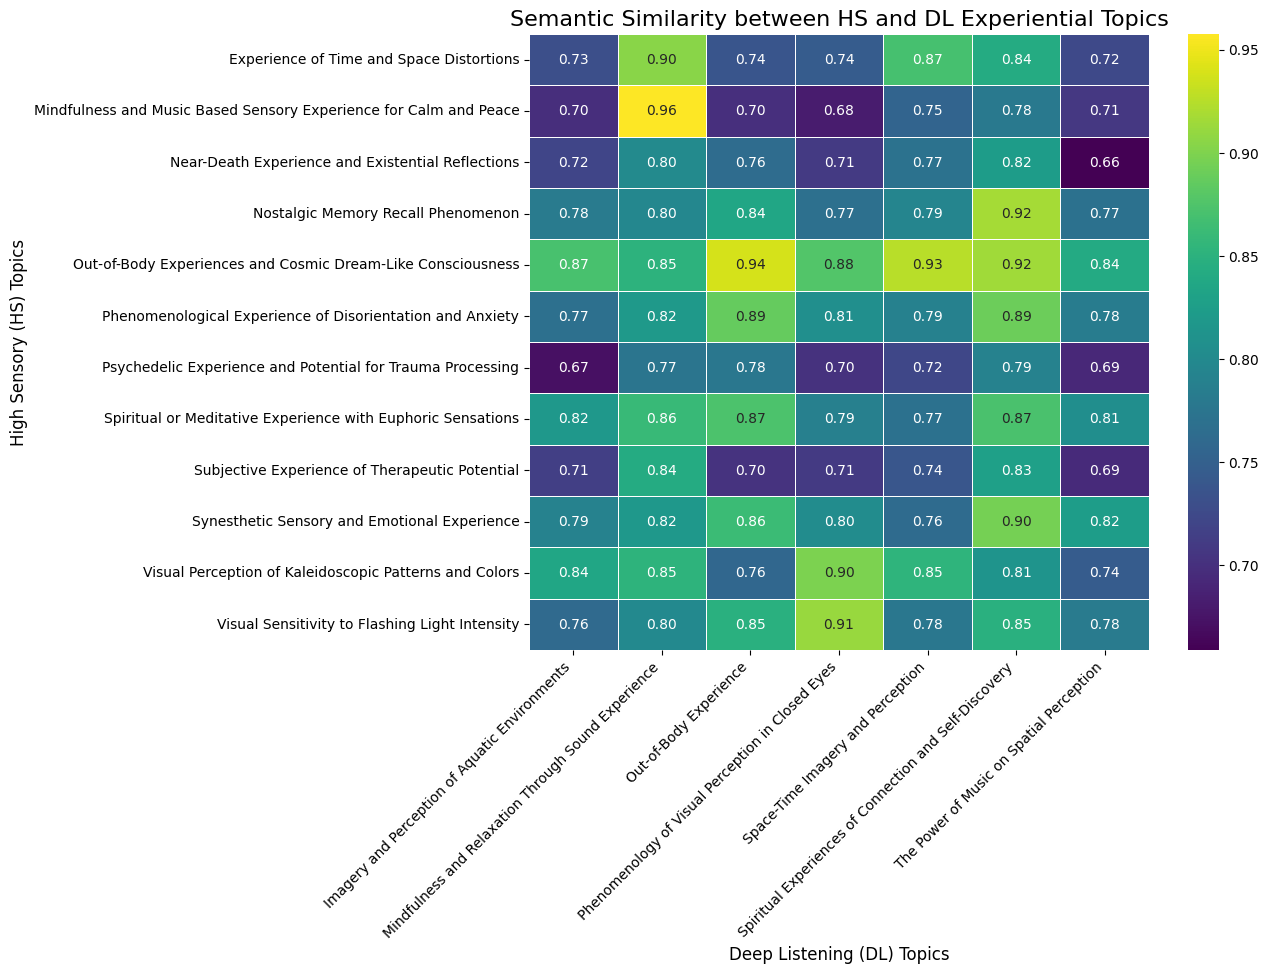

In [105]:
print("\n--- Generating Heatmap ---")

plt.figure(figsize=(10, 8))
sns.heatmap(
    similarity_matrix,
    annot=True,          # Show the similarity scores in each cell
    cmap='viridis',      # Use a color-friendly palette
    linewidths=.5,
    fmt=".2f"            # Format scores to two decimal places
)
plt.title('Semantic Similarity between HS and DL Experiential Topics', fontsize=16)
plt.xlabel('Deep Listening (DL) Topics', fontsize=12)
plt.ylabel('High Sensory (HS) Topics', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()




In [106]:

# A score > threshold will be considered "shared".
SIMILARITY_THRESHOLD = 0.85  

print(f"--- Analyzing Matches with Threshold: {SIMILARITY_THRESHOLD} ---")


shared_topics = []
# Start by assuming all topics are unique
unique_hs_topics = list(similarity_matrix.index)
unique_dl_topics = list(similarity_matrix.columns)

# use a "greedy" approach: find the highest similarity pair first,
# mark those topics as "shared," and remove them from consideration.
# This helps prevent one topic from being "matched" to multiple others.

# Make a copy of the matrix to modify
matrix_copy = similarity_matrix.copy()

while True:
    # Find the absolute highest similarity score left in the matrix
    max_score = matrix_copy.max().max()
    
    # If the highest score is below our threshold, we're done
    if max_score < SIMILARITY_THRESHOLD:
        print("\nNo more matches found above threshold.")
        break
        
    # Find the (HS, DL) topic pair for this max score.
    # .stack() turns the DataFrame into a Series with a (row, col) MultiIndex.
    # .idxmax() finds the (row, col) index pair for the highest value.
    hs_topic, dl_topic = matrix_copy.stack().idxmax()
    score = max_score

    shared_topics.append((hs_topic, dl_topic, score))
    
    # Remove these topics from our "unique" lists
    if hs_topic in unique_hs_topics:
        unique_hs_topics.remove(hs_topic)
    if dl_topic in unique_dl_topics:
        unique_dl_topics.remove(dl_topic)
    
    # "Remove" these topics from the matrix so they aren't matched again

    matrix_copy.loc[hs_topic, :] = 0
    matrix_copy.loc[:, dl_topic] = 0
    
    print(f"Found Match: {hs_topic} (HS) <-> {dl_topic} (DL) | Score: {score:.3f}")




print("\n\n--- Analysis Complete ---")

print(f"\n **Shared Topic Pairs (Score > {SIMILARITY_THRESHOLD}):**")
if shared_topics:
    for hs, dl, score in shared_topics:
        print(f"  * HS: '{hs}'  <->  DL: '{dl}' (Similarity: {score:.3f})")
else:
    print("  No shared topics found with this threshold.")
    
print(f"\n**Unique HS Topics (No match in DL):**")
if unique_hs_topics:
    for topic in unique_hs_topics:
        print(f"  * {topic}")
else:
    print("  No unique HS topics found.")

print(f"\n**Unique DL Topics (No match in HS):**")
if unique_dl_topics:
    for topic in unique_dl_topics:
        print(f"  * {topic}")
else:
    print("  No unique DL topics found.")

--- Analyzing Matches with Threshold: 0.85 ---
Found Match: Mindfulness and Music Based Sensory Experience for Calm and Peace (HS) <-> Mindfulness and Relaxation Through Sound Experience (DL) | Score: 0.958
Found Match: Out-of-Body Experiences and Cosmic Dream-Like Consciousness (HS) <-> Out-of-Body Experience (DL) | Score: 0.938
Found Match: Nostalgic Memory Recall Phenomenon (HS) <-> Spiritual Experiences of Connection and Self-Discovery (DL) | Score: 0.917
Found Match: Visual Sensitivity to Flashing Light Intensity (HS) <-> Phenomenology of Visual Perception in Closed Eyes (DL) | Score: 0.911
Found Match: Experience of Time and Space Distortions (HS) <-> Space-Time Imagery and Perception (DL) | Score: 0.869

No more matches found above threshold.


--- Analysis Complete ---

 **Shared Topic Pairs (Score > 0.85):**
  * HS: 'Mindfulness and Music Based Sensory Experience for Calm and Peace'  <->  DL: 'Mindfulness and Relaxation Through Sound Experience' (Similarity: 0.958)
  * HS: 'Ou

In [107]:
# Create a merged contingency table that combines paired HS↔DL topics and preserves unpaired topics.
# Assumes these variables already exist in the notebook: shared_topics, hs_counts, dl_counts, unique_hs_topics, unique_dl_topics, results_dir

rows = []

# Add paired topics (from shared_topics: list of (hs_topic, dl_topic, score))
for hs_topic, dl_topic, score in shared_topics:
    rows.append({
        "theme": f"{hs_topic} / {dl_topic}",
        "hs_topic": hs_topic,
        "dl_topic": dl_topic,
        "HS": int(hs_counts.get(hs_topic, 0)),
        "DL": int(dl_counts.get(dl_topic, 0)),
        "type": "paired",
        "cosine": float(score),
    })

# Add HS-specific (unmatched) topics
matched_hs = {hs for hs, dl, _ in shared_topics}
for hs in unique_hs_topics:
    if hs in matched_hs:
        continue
    rows.append({
        "theme": hs,
        "hs_topic": hs,
        "dl_topic": "N/A",
        "HS": int(hs_counts.get(hs, 0)),
        "DL": 0,
        "type": "HS-specific",
        "cosine": float("nan"),
    })

# Add DL-specific (unmatched) topics
matched_dl = {dl for hs, dl, _ in shared_topics}
for dl in unique_dl_topics:
    if dl in matched_dl:
        continue
    rows.append({
        "theme": dl,
        "hs_topic": "N/A",
        "dl_topic": dl,
        "HS": 0,
        "DL": int(dl_counts.get(dl, 0)),
        "type": "DL-specific",
        "cosine": float("nan"),
    })

merged_contingency = pd.DataFrame(rows).set_index("theme")[["hs_topic", "dl_topic", "HS", "DL", "type", "cosine"]]

# sort by total counts (HS+DL) descending for readability
merged_contingency["total"] = merged_contingency["HS"] + merged_contingency["DL"]
merged_contingency = merged_contingency.sort_values("total", ascending=False).drop(columns="total")

# show and save
print(merged_contingency)
merged_contingency.to_csv(os.path.join(results_dir, "merged_contingency_table.csv"))

                                                                                             hs_topic  \
theme                                                                                                   
Visual Perception of Kaleidoscopic Patterns and...  Visual Perception of Kaleidoscopic Patterns an...   
Out-of-Body Experiences and Cosmic Dream-Like C...  Out-of-Body Experiences and Cosmic Dream-Like ...   
Mindfulness and Music Based Sensory Experience ...  Mindfulness and Music Based Sensory Experience...   
Experience of Time and Space Distortions / Spac...           Experience of Time and Space Distortions   
Nostalgic Memory Recall Phenomenon / Spiritual ...                 Nostalgic Memory Recall Phenomenon   
Visual Sensitivity to Flashing Light Intensity ...     Visual Sensitivity to Flashing Light Intensity   
Spiritual or Meditative Experience with Euphori...  Spiritual or Meditative Experience with Euphor...   
Subjective Experience of Therapeutic Potential         

In [108]:
merged_contingency

,hs_topic,dl_topic,HS,DL,type,cosine
theme,,,,,,
Visual Perception of Kaleidoscopic Patterns and Colors,Visual Perception of Kaleidoscopic Patterns an...,N/A,191,0,HS-specific,NaN
Out-of-Body Experiences and Cosmic Dream-Like Consciousness / Out-of-Body Experience,Out-of-Body Experiences and Cosmic Dream-Like ...,Out-of-Body Experience,125,16,paired,0.938391
Mindfulness and Music Based Sensory Experience for Calm and Peace / Mindfulness and Relaxation Through Sound Experience,Mindfulness and Music Based Sensory Experience...,Mindfulness and Relaxation Through Sound Exper...,54,50,paired,0.957555
Experience of Time and Space Distortions / Space-Time Imagery and Perception,Experience of Time and Space Distortions,Space-Time Imagery and Perception,58,15,paired,0.869407
Nostalgic Memory Recall Phenomenon / Spiritual Experiences of Connection and Self-Discovery,Nostalgic Memory Recall Phenomenon,Spiritual Experiences of Connection and Self-D...,29,41,paired,0.917145
Visual Sensitivity to Flashing Light Intensity / Phenomenology of Visual Perception in Closed Eyes,Visual Sensitivity to Flashing Light Intensity,Phenomenology of Visual Perception in Closed Eyes,24,27,paired,0.910941
Spiritual or Meditative Experience with Euphoric Sensations,Spiritual or Meditative Experience with Euphor...,N/A,40,0,HS-specific,NaN
Subjective Experience of Therapeutic Potential,Subjective Experience of Therapeutic Potential,N/A,33,0,HS-specific,NaN
Synesthetic Sensory and Emotional Experience,Synesthetic Sensory and Emotional Experience,N/A,27,0,HS-specific,NaN


--- Chi-Squared Test Results ---
Chi-squared statistic (χ²): 343.05
Degrees of Freedom (dof): 13
P-value: 0.0000

--- Interpretation ---
The p-value (0.0000) is less than 0.05, indicating a statistically significant association
between the condition (HS/DL) and the experiential themes reported.


--- Generating Final Bar Chart ---


/var/folders/1d/q_0fy53s0jdcsc1sb09wkntw00z7v7/T/ipykernel_89542/995143503.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(formatted_labels)



Chart saved as /Users/rb666/Projects/MOSAIC/EVAL/dreamachine/topic_frequency_comparison.png
Chart saved as /Users/rb666/Projects/MOSAIC/EVAL/dreamachine/topic_frequency_comparison.pdf


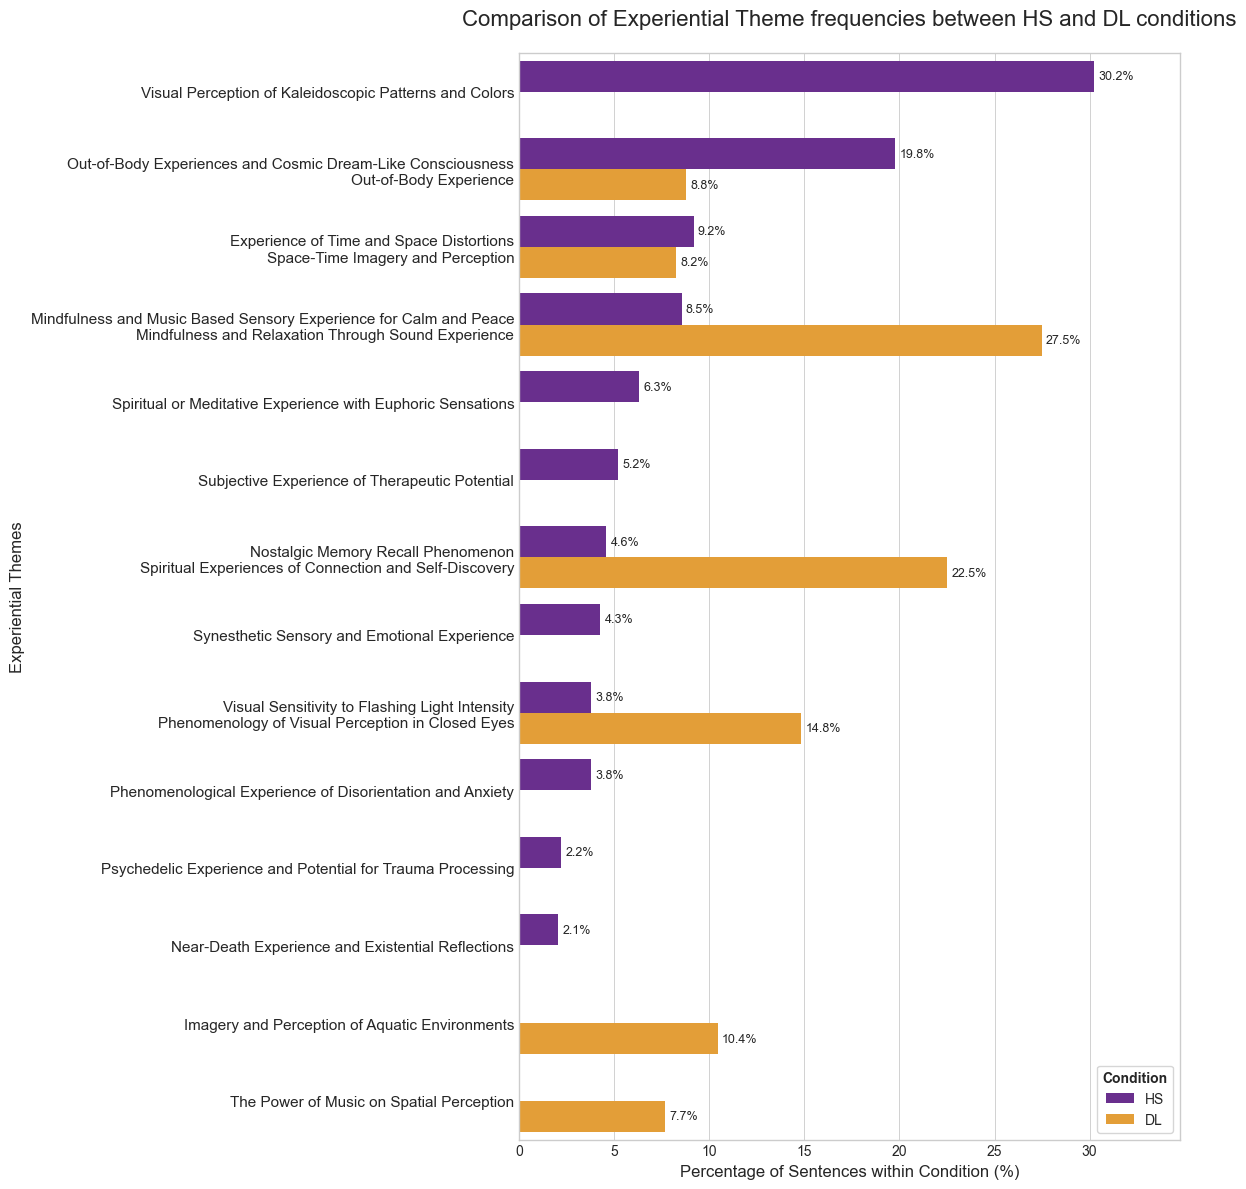

In [111]:
# %% [markdown]
# ### 4. Final Frequency Comparison Chart (Formatted)
# 
# This code generates the final comparative bar chart.
# It now formats merged topic labels onto two lines for readability.

# %%
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Prepare Data for Test ---
# We only need the raw counts for the Chi-Squared test.
# The 'merged_contingency' DataFrame should exist from the previous cell.
counts_df = merged_contingency[['HS', 'DL']]

# --- Step 2: Perform the Chi-Squared Test ---

print("--- Chi-Squared Test Results ---")
# Check if there are at least 2 topics to compare
if counts_df.shape[0] >= 2 and counts_df.shape[1] >= 2:
    try:
        chi2, p_value, dof, expected = chi2_contingency(counts_df)
        print(f"Chi-squared statistic (χ²): {chi2:.2f}")
        print(f"Degrees of Freedom (dof): {dof}")
        print(f"P-value: {p_value:.4f}")

        # --- Interpretation ---
        print("\n--- Interpretation ---")
        alpha = 0.05
        if p_value < alpha:
            print(f"The p-value ({p_value:.4f}) is less than {alpha}, indicating a statistically significant association")
            print("between the condition (HS/DL) and the experiential themes reported.")
        else:
            print(f"The p-value ({p_value:.4f}) is not less than {alpha}, indicating no statistically significant association.")
    except ValueError as e:
        print(f"Could not perform Chi-Squared test. Error: {e}")
        print("This can happen if one condition (HS or DL) has a sum of 0.")
else:
    print("Not enough data to perform a Chi-Squared test (need at least 2 rows and 2 columns).")
    
print("\n" + "="*50 + "\n")


# --- Step 3: Create the Comparative Bar Chart ---

print("--- Generating Final Bar Chart ---")

# Calculate percentages within each condition to normalise for sample size
percentage_table = counts_df.div(counts_df.sum(axis=0), axis=1) * 100

# Sort the topics by the percentage in the HS condition
percentage_table_sorted = percentage_table.fillna(0)
sorted_order = percentage_table_sorted.sort_values(by='HS', ascending=False).index

# *** NEW: Create formatted labels for the y-axis ***
# This replaces " / " with a newline character ("\n")
formatted_labels = [label.replace(' / ', '\n') for label in sorted_order]

# Prepare the data for plotting by "melting" the dataframe
plot_data = percentage_table.reset_index().melt(
    id_vars='theme', 
    var_name='Condition', 
    value_name='Percentage'
)

# --- Create the Plot (Styled like your example image) ---
plt.style.use('seaborn-v0_8-whitegrid')
# *** UPDATED: Increased figure height for two-line labels ***
fig, ax = plt.subplots(figsize=(12, 12)) 

# Use the exact colors from your example chart
palette_colors = {'HS': "#6d1f9d", 'DL': "#ffa41c"} # Purple / Orange

sns.barplot(
    data=plot_data,
    y='theme',           
    x='Percentage',
    hue='Condition',
    palette=palette_colors,
    order=sorted_order,  # This still correctly orders the data
    ax=ax
)

# *** NEW: Apply the formatted, two-line labels to the y-axis ***
ax.set_yticklabels(formatted_labels)

# --- Formatting (to match your example) ---
ax.set_title('Comparison of Experiential Theme frequencies between HS and DL conditions', fontsize=16, pad=20)
ax.set_xlabel('Percentage of Sentences within Condition (%)', fontsize=12)
ax.set_ylabel('Experiential Themes', fontsize=12)
ax.tick_params(axis='y', labelsize=11) # Y-axis labels
ax.grid(axis='y', which='both', linestyle='',alpha=0) # Remove horizontal gridlines
ax.grid(axis='x', which='major', linestyle='-', linewidth=0.5, color='grey', alpha=0.5) # Keep vertical gridlines


# Format legend
legend = ax.legend(title='Condition', loc='lower right', frameon=True, facecolor='white', shadow=False)
legend.get_title().set_fontweight('bold')

# Add percentage labels to the bars
for container in ax.containers:
    # Filter out 0% labels to avoid clutter
    labels = [f'{v:.1f}%' if v > 0 else '' for v in container.datavalues]
    ax.bar_label(
        container, 
        labels=labels, 
        label_type='edge', 
        fontsize=9, 
        padding=3
    )

# Adjust x-axis limit to give space for labels
max_percentage = plot_data['Percentage'].max()
ax.set_xlim(0, max_percentage * 1.15) 

plt.tight_layout()

# Save the figure
save_path = os.path.join(results_dir, "topic_frequency_comparison.png")
plt.savefig(save_path, dpi=300)
print(f"\nChart saved as {save_path}")

pdf_save_path = os.path.join(results_dir, "topic_frequency_comparison.pdf")
plt.savefig(pdf_save_path, format='pdf', bbox_inches='tight')
print(f"Chart saved as {pdf_save_path}")

# Show the plot
plt.show()

--- Chi-Squared Test Results ---
Chi-squared statistic (χ²): 343.05
Degrees of Freedom (dof): 13
P-value: 0.0000

--- Interpretation ---
The p-value (0.0000) is less than 0.05, indicating a statistically significant association
between the condition (HS/DL) and the experiential themes reported.


--- Generating Final Bar Chart ---


/var/folders/1d/q_0fy53s0jdcsc1sb09wkntw00z7v7/T/ipykernel_89542/1029298793.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(formatted_labels)



Chart saved as /Users/rb666/Projects/MOSAIC/EVAL/dreamachine/topic_frequency_comparison.png
Chart saved as /Users/rb666/Projects/MOSAIC/EVAL/dreamachine/topic_frequency_comparison.pdf


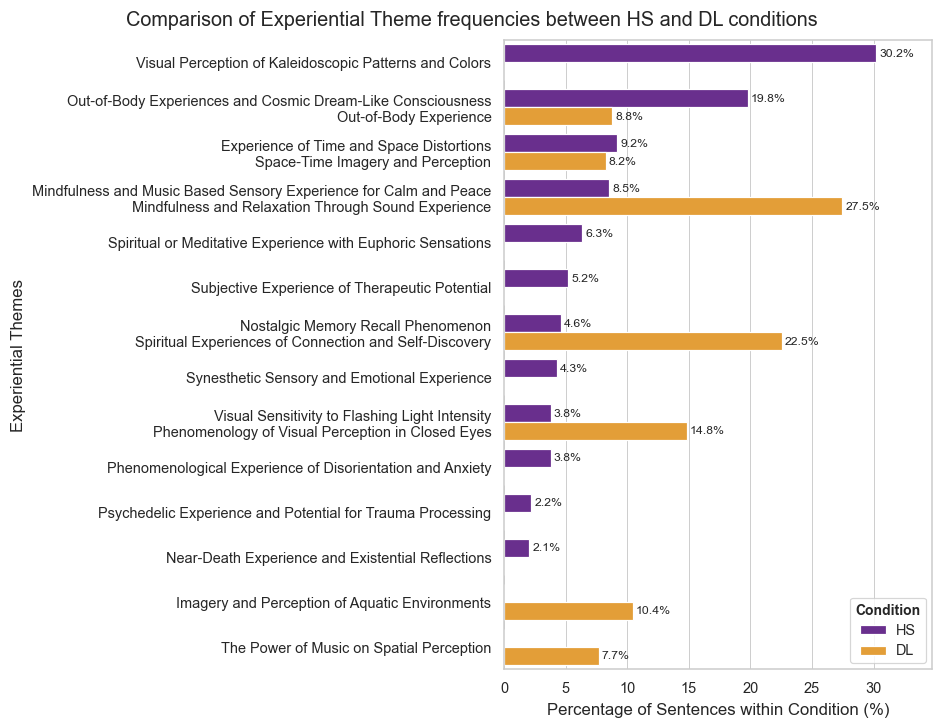

In [ ]:
# %%
import os
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# --- Display & export tweaks ---
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=0.95)  # smaller fonts suited for print
rcParams["figure.dpi"] = 110               # on-screen preview
rcParams["savefig.dpi"] = 600              # high-quality PNG export
rcParams["pdf.fonttype"] = 42              # editable text in vector editors
rcParams["ps.fonttype"] = 42

# --- Step 1: Prepare Data for Test ---
counts_df = merged_contingency[['HS', 'DL']]

# --- Step 2: Perform the Chi-Squared Test ---
print("--- Chi-Squared Test Results ---")
if counts_df.shape[0] >= 2 and counts_df.shape[1] >= 2:
    try:
        chi2, p_value, dof, expected = chi2_contingency(counts_df)
        print(f"Chi-squared statistic (χ²): {chi2:.2f}")
        print(f"Degrees of Freedom (dof): {dof}")
        print(f"P-value: {p_value:.4f}")

        print("\n--- Interpretation ---")
        alpha = 0.05
        if p_value < alpha:
            print(f"The p-value ({p_value:.4f}) is less than {alpha}, indicating a statistically significant association")
            print("between the condition (HS/DL) and the experiential themes reported.")
        else:
            print(f"The p-value ({p_value:.4f}) is not less than {alpha}, indicating no statistically significant association.")
    except ValueError as e:
        print(f"Could not perform Chi-Squared test. Error: {e}")
        print("This can happen if one condition (HS or DL) has a sum of 0.")
else:
    print("Not enough data to perform a Chi-Squared test (need at least 2 rows and 2 columns).")

print("\n" + "="*50 + "\n")

# --- Step 3: Create the Comparative Bar Chart ---
print("--- Generating Final Bar Chart ---")

# Percentages within each condition
percentage_table = counts_df.div(counts_df.sum(axis=0), axis=1) * 100

# Order topics by HS percentage
percentage_table_sorted = percentage_table.fillna(0)
sorted_order = percentage_table_sorted.sort_values(by='HS', ascending=False).index

# Two-line labels
formatted_labels = [label.replace(' / ', '\n') for label in sorted_order]

# Melt for seaborn
plot_data = percentage_table.reset_index().melt(
    id_vars='theme',
    var_name='Condition',
    value_name='Percentage'
)

# --- Size: dynamic, compact, but readable ---
n_topics = len(sorted_order)
height_per_row = 0.38   # inches per topic (adjust if needed)
min_h, max_h = 4.0, 9.0 # clamp extremes so it never gets too tall
fig_h = min(max(min_h, n_topics * height_per_row + 1.2), max_h)

fig, ax = plt.subplots(figsize=(8.5, fig_h))  # narrower and shorter than before

palette_colors = {'HS': "#6d1f9d", 'DL': "#ffa41c"}  # Purple / Orange

sns.barplot(
    data=plot_data,
    y='theme',
    x='Percentage',
    hue='Condition',
    palette=palette_colors,
    order=sorted_order,
    ax=ax
)

# Apply two-line y tick labels
ax.set_yticklabels(formatted_labels)

# Formatting
# ax.set_title('Comparison of Experiential Theme frequencies between HS and DL conditions', fontsize=13, pad=12)
fig.suptitle(
    'Comparison of Experiential Theme frequencies between HS and DL conditions',
    fontsize=13, y=0.995, ha='center'
)
plt.tight_layout(rect=[0, 0, 1, 0.96])

ax.set_xlabel('Percentage of Sentences within Condition (%)', fontsize=11)
ax.set_ylabel('Experiential Themes', fontsize=11)
ax.tick_params(axis='y', labelsize=9.5)
ax.tick_params(axis='x', labelsize=9.5)
ax.grid(axis='y', which='both', linestyle='', alpha=0)
ax.grid(axis='x', which='major', linestyle='-', linewidth=0.5, color='grey', alpha=0.5)

# Legend
legend = ax.legend(title='Condition', loc='lower right', frameon=True, facecolor='white', shadow=False)
legend.get_title().set_fontweight('bold')
for text in legend.get_texts():
    text.set_fontsize(9.5)

# Labels on bars (skip zeros)
for container in ax.containers:
    labels = [f'{v:.1f}%' if v > 0 else '' for v in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='edge', fontsize=8, padding=2)

# Give a bit of headroom to the longest bar labels
max_percentage = float(plot_data['Percentage'].max()) if len(plot_data) else 0
ax.set_xlim(0, max_percentage * 1.15)

plt.tight_layout(pad=0.5)

# --- Save high-quality exports ---
png_path = os.path.join(results_dir, "topic_frequency_comparison.png")
pdf_path = os.path.join(results_dir, "topic_frequency_comparison.pdf")

# PNG: high DPI + tight bbox to avoid huge whitespace
plt.savefig(
    png_path,
    dpi=600,
    bbox_inches='tight',
    pad_inches=0.05,
    facecolor='white'
)
print(f"\nChart saved as {png_path}")


plt.savefig(
    pdf_path,
    format='pdf',
    bbox_inches='tight',
    pad_inches=0.05
)
print(f"Chart saved as {pdf_path}")

plt.show()
